In [1]:
# IMPORTS

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import ast
from matplotlib.animation import FuncAnimation, PillowWriter
from geopy import distance
from sklearn import linear_model
import statsmodels.api as sm

plt.ioff()

In [2]:
# # IMPORT DATA

# directory = '.\Data'
# all_files = os.listdir(directory)
# csv_files = [f for f in all_files if f.startswith('CAMP') and f.endswith('csv')]

# data_list = []

# for file in csv_files:
#     file_path = os.path.join(directory, file)
#     df = pd.read_csv(file_path, encoding='latin-1')
#     data_list.append(df)

# data_concat = pd.concat(data_list, ignore_index=True)

# # DROP UNUSED COLUMNS
# data_concat = data_concat.drop(columns=['OBJECTID', 'NUMERO_ORDINE', 'TECNICO', 'ID', 'TIPOLOGIA'])

# # ADJUST DATE FORMAT
# data_concat['DATA_RILEVAMENTO'] = pd.to_datetime(data_concat.DATA_RILEVAMENTO, format='mixed')

# # ADJUST SPECIES NAMES
# # Remove non-species
# data_concat = data_concat[~data_concat['SPECIE'].isin(['06', '****', 'nan']) & ~data_concat['SPECIE'].isna()]

# # Group same species under same name (replacement dictionaries are in 'Species.txt')
# with open('Species.txt', 'r') as file:
#     file_content = file.read()

# replacement_dict_list = ast.literal_eval(file_content)
# for replacement_dict in replacement_dict_list:
#     data_concat['SPECIE'] = data_concat['SPECIE'].replace(replacement_dict)

# # ADJUST CASE IN OTHER COLUMNS
# column_list = ['CULTIVAR', 'RISULTATO', 'COMUNE', 'SINTOMO']

# for column in column_list:
#     data_concat[column] = data_concat[column].str.capitalize()

# # SORT BY DATE
# data_concat = data_concat.sort_values(by='DATA_RILEVAMENTO')

# # REMOVE ROWS WITH NO COORDINATE DATA
# data_concat = data_concat.dropna(subset=['LATITUDINE', 'LONGITUDINE'])

# # REMOVE WRONG DATA
# lat_min = 39.0
# lon_max = 18.9
# mask = (data_concat['LATITUDINE'] < lat_min) & (data_concat['LONGITUDINE'] > lon_max)
# data_concat = data_concat[~mask]

# # ADD COLUMN WITH DISTANCE FROM EPICENTRE
# epicentre_point = (40.055851, 17.992615) # Taken from Kottelenberg (2021)
# data_concat['DISTANCE'] = data_concat.apply(lambda row: distance.distance(epicentre_point, (row['LATITUDINE'], row['LONGITUDINE'])).km, axis=1)

# # EXPORT CLEANED DATAFRAME
# data_concat.to_csv('.\Data\Dati_monitoraggio_2013-2023.csv', index=False)

In [3]:
# IMPORT CLEANED DATAFRAME
data_concat = pd.read_csv('.\Data\Dati_monitoraggio_2013-2023.csv', low_memory=False)
data_concat['DATA_RILEVAMENTO'] = pd.to_datetime(data_concat['DATA_RILEVAMENTO'])
data_concat.head()

,DATA_RILEVAMENTO,SPECIE,LATITUDINE,LONGITUDINE,CULTIVAR,RISULTATO,COMUNE,SINTOMO,DISTANCE
0,2013-11-13,Olivo (Olea europaea),40.053056,18.363611,****,Negativo,Poggiardo,NaN,31.657108
1,2013-11-13,Olivo (Olea europaea),40.326389,18.372500,****,Negativo,Melendugno,NaN,44.146012
2,2013-11-13,Vite (di ogni specie),40.213611,18.447778,****,Negativo,Otranto,NaN,42.563322
3,2013-11-13,Vite (di ogni specie),40.191944,18.448889,****,Negativo,Otranto,NaN,41.724979
4,2013-11-13,Vite (di ogni specie),40.179444,18.461111,****,Negativo,Otranto,NaN,42.229925


In [4]:
# CREATE MAP FUNCTION
def create_map(limits, ax, resolution):
    lat_min, lat_max, lon_min, lon_max = limits
    m = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2, lon_0=(lon_max-lon_min)/2,
                projection='merc', resolution=resolution, area_thresh=10000., ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color='white',lake_color='#46bcec')
    return m

# MAP LIMITS
def get_limits(lat, lon, margin=0.1):    
    lat_min = np.min(lat) - margin
    lat_max = np.max(lat) + margin
    lon_min = np.min(lon) - margin
    lon_max = np.max(lon) + margin
    limits = [lat_min, lat_max, lon_min, lon_max]
    return limits

In [5]:
# MODIFY ORIGINAL DATAFRAME
# Colors
color_map = {'Positivo': 'red', 'Negativo': 'green'}
data_concat['COLOR'] = data_concat['RISULTATO'].map(color_map)


# GLOBAL VARIABLES
lat = data_concat['LATITUDINE'].values
lon = data_concat['LONGITUDINE'].values
limits = get_limits(lat, lon, margin=0.1)

year_list = data_concat['DATA_RILEVAMENTO'].dt.year.unique()
positives = data_concat[data_concat['RISULTATO'] == 'Positivo'].copy()

In [6]:
# # PLOT ALL SAMPLES
# # Map margins

# fig, ax = plt.subplots(figsize=(12,12))
# m = create_map(limits, ax, 'i')
# lons, lats = m(lon, lat)
# sc = m.scatter(lons, lats, c=data_concat['COLOR'].values, marker='o', s=10, edgecolor='none', alpha=0.7)

# # Legend
# for condition in color_map:
#     ax.scatter([], [], c=color_map[condition], edgecolor='none', alpha=0.7, s=100, label=condition)
# ax.legend(title='Condition', loc='lower left')

# year_min = np.min(year_list)
# year_max = np.max(year_list)
# plt.title(f'All samples taken {year_min}-{year_max}')
# plt.savefig('Images/All_samples_2013-2023.png', dpi=300)
# plt.show()

In [7]:
# # PLOT ALL SAMPLES YEAR BY YEAR
# nrows = 3
# ncols = 4
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6))

# for i, year in enumerate(year_list):
#     yearly_data = data_concat[data_concat['DATA_RILEVAMENTO'].dt.year == year]
    
#     yearly_lat = yearly_data['LATITUDINE'].values
#     yearly_lon = yearly_data['LONGITUDINE'].values
#     row = i // ncols
#     col = i % ncols

#     m = create_map(limits, ax[row,col], 'i')
#     yearly_lons, yearly_lats = m(yearly_lon, yearly_lat)
#     sc = m.scatter(yearly_lons, yearly_lats, c=yearly_data['COLOR'].values, marker='o', s=0.5, edgecolor='none', alpha=0.7)

#     for condition in color_map:
#         ax[row,col].scatter([], [], c=color_map[condition], edgecolor='none', alpha=0.7, s=100, label=condition)
#         ax[row,col].legend(title='Condition', loc='lower left')
#     ax[row,col].set_title(f'Samples {year}')
# ax[-1,-1].axis('off')

# # fig.suptitle('Yearly positive samples', fontsize=16)
# plt.savefig('Images/Yearly_samples_2013-2023.png', dpi=300)
# plt.close(fig)

In [8]:
# # PLOT POSITIVE SAMPLES YEAR BY YEAR
# nrows = 3
# ncols = 4
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

# for i, year in enumerate(year_list):
#     yearly_data = positives[positives['DATA_RILEVAMENTO'].dt.year == year]
    
#     yearly_lat = yearly_data['LATITUDINE'].values
#     yearly_lon = yearly_data['LONGITUDINE'].values    
#     row = i // ncols
#     col = i % ncols

#     m = create_map(limits, ax[row,col], 'i')
#     yearly_lons, yearly_lats = m(yearly_lon, yearly_lat)
#     sc = m.scatter(yearly_lons, yearly_lats, c=yearly_data['COLOR'].values, marker='o', s=0.5, edgecolor='none', alpha=0.7)
#     ax[row,col].set_title(f'Samples {year}')

# ax[-1,-1].axis('off')

# # fig.suptitle('Yearly positive samples', fontsize=16)
# plt.savefig('Images/Positive_samples_2013-2023.png', dpi=300)
# plt.close(fig)

In [9]:
# # # PLOT FIRST N POSITIVE SAMPLES AND ANIMATE
# N = 100
# first_positives = positives[:N]

# # Coordinate data of samples
# first_lat = first_positives['LATITUDINE'].values
# first_lon = first_positives['LONGITUDINE'].values
# limits = get_limits(first_lat, first_lon, margin=0.1)

# fig, ax = plt.subplots(figsize=(8,8))
# m = create_map(limits, ax, 'i')
# first_lons, first_lats = m(first_lon, first_lat)
# sc = m.scatter(first_lons, first_lats, c=first_positives['COLOR'].values, marker='o', s=10, edgecolor='none', alpha=0.7)

# plt.title(f'First {N} positive samples')
# plt.savefig(f'Images/First_{N}_Positive_samples.png', dpi=300)
# plt.close(fig)

# # Animation
# fig, ax = plt.subplots(figsize=(8,8))
# m = create_map(limits, ax, 'i')

# # Function to update scatter plot for each frame
# def update(frame):
#     ax.clear()
#     m.drawcoastlines()
#     m.drawcountries()
#     m.drawstates()
#     m.drawmapboundary(fill_color='#46bcec')
#     m.fillcontinents(color='white',lake_color='#46bcec')
    
#     current_date = unique_dates[frame]
#     current_data = first_positives[first_positives['DATA_RILEVAMENTO'] <= current_date]
    
#     x, y = m(current_data['LONGITUDINE'].values, current_data['LATITUDINE'].values)
#     sc = m.scatter(x, y, c=current_data['COLOR'].values, marker='o', s=10, edgecolor='none', alpha=0.7)    
#     ax.set_title(f'Test Results as of {current_date.date()}')

# unique_dates = first_positives['DATA_RILEVAMENTO'].unique()
# ani = FuncAnimation(fig, update, frames=len(unique_dates), repeat=False)
# ani.save(f'Images/First_{N}_Positive_samples_evolution.gif',
#           writer=PillowWriter(fps=10))
# plt.close(fig)

# Speed estimation

In [10]:
# Evaluate max distance evolution
positives['POSITIVE_INDEX'] = np.arange(len(positives)) # Add an index from 0 to len(positives)

indices = []
max_distance_so_far = 0.0
for index, row in positives.iterrows():
    dist = row['DISTANCE']
    if dist > max_distance_so_far:
        max_distance_so_far = dist
        indices.append(row['POSITIVE_INDEX'])

df_max_distances = positives.iloc[indices].copy()

In [11]:
# CALCULATE SPEED OF DISEASE SPREAD
positives['ORDINAL'] = pd.to_datetime(positives['DATA_RILEVAMENTO']).apply(lambda x: x.toordinal())
df_max_distances['ORDINAL'] = pd.to_datetime(df_max_distances['DATA_RILEVAMENTO']).apply(lambda x: x.toordinal())

# All years
X = df_max_distances[['ORDINAL']]
X_i = np.zeros((len(X), 2))
X_i[:, 0] = 1
X_i[:, 1:] = X.values

X_pred = positives[['ORDINAL']]
X_pred_i = np.zeros((len(X_pred), 2))
X_pred_i[:, 0] = 1
X_pred_i[:, 1:] = X_pred.values

y = df_max_distances['DISTANCE']
ols = sm.OLS(y.values, X_i).fit()
y_pred = ols.predict(X_pred_i)

speed = ols.params[1]
err = ols.bse[1]

# Max year 2017
max_year = 2017
X1 = X[df_max_distances['DATA_RILEVAMENTO'].dt.year < max_year]
X1_i = np.zeros((len(X1), 2))
X1_i[:, 0] = 1
X1_i[:, 1:] = X1.values

X_pred1 = X_pred[positives['DATA_RILEVAMENTO'].dt.year < max_year]
X_pred1_i = np.zeros((len(X_pred1), 2))
X_pred1_i[:, 0] = 1
X_pred1_i[:, 1:] = X_pred1.values

y1 = y[df_max_distances['DATA_RILEVAMENTO'].dt.year < max_year]
ols1 = sm.OLS(y1.values, X1_i).fit()
y_pred1 = ols1.predict(X_pred1_i)

speed1 = ols1.params[1]
err1 = ols1.bse[1]

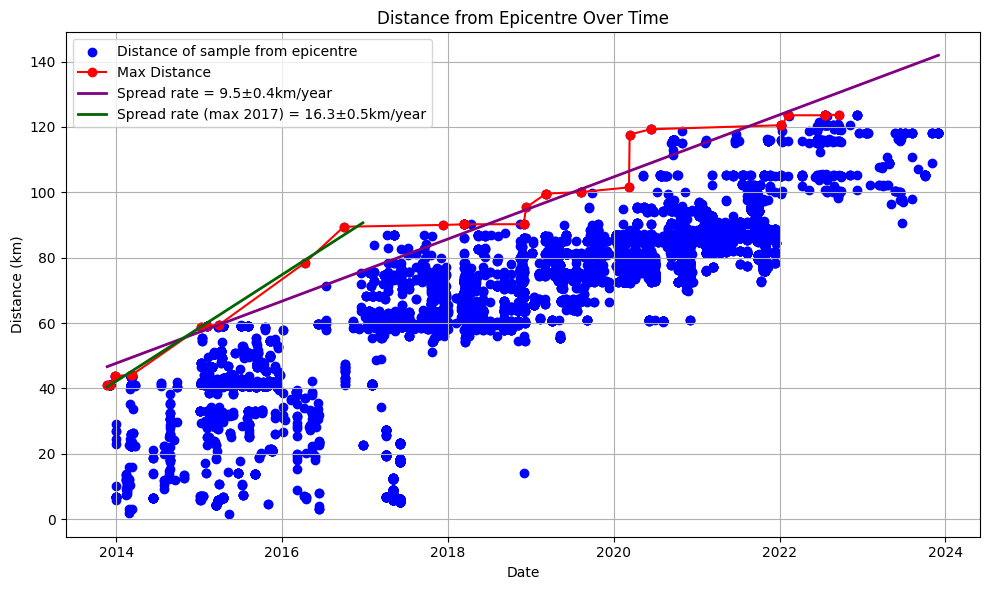

In [12]:
# PLOT ALL DISTANCES
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(positives['DATA_RILEVAMENTO'], positives['DISTANCE'], marker='o', linestyle='-', color='b', label='Distance of sample from epicentre')
ax.plot(df_max_distances['DATA_RILEVAMENTO'], df_max_distances['DISTANCE'], marker='o', linestyle='-', color='r', label='Max Distance')
ax.plot(positives['DATA_RILEVAMENTO'], y_pred, color='purple', linewidth=2, label=f'Spread rate = {np.round(speed*365,1)}±{np.round(err*365,1)}km/year')
ax.plot(positives[positives['DATA_RILEVAMENTO'].dt.year < max_year]['DATA_RILEVAMENTO'], y_pred1, color='darkgreen', linewidth=2, label=f'Spread rate (max {max_year}) = {np.round(speed1*365,1)}±{np.round(err1*365,1)}km/year')
ax.set_xlabel('Date')
ax.set_ylabel('Distance (km)')
ax.set_title('Distance from Epicentre Over Time')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

In [13]:
# KOTTELENBERG METHOD

max_dist = int(np.rint(np.max(data_concat['DISTANCE'])))
max_pos = int(np.rint(np.max(data_concat[data_concat['RISULTATO'] == 'Positivo']['DISTANCE'])))
data_concat['CLASS'] = np.int32(np.ceil(data_concat['DISTANCE']))

In [14]:
def class_data(year):
    yearly_data = data_concat[data_concat['DATA_RILEVAMENTO'].dt.year == year]
    dist_list = np.arange(1, max_dist+1)
    pos_list = []
    n_list = []
    for Class in dist_list:
        class_data = yearly_data[yearly_data['CLASS'] == Class]
        n_list.append(len(class_data))
        pos_list.append(len(class_data[class_data['RISULTATO'] == 'Positivo']))

    class_dict = {'dist':np.array(dist_list), 'pos':np.array(pos_list), 'n':np.array(n_list)}
    return class_dict

In [17]:
from scipy.optimize import minimize
from scipy.stats import binom

def fun_log_binom(par, x, z, n, year):
    x50, c = par
    mu = 1 / (1 + np.exp(x - (x50 + (year - 2013) * c)))
    
    mu = np.clip(mu, 1e-10, 1 - 1e-10)
    mask = n > 0
    nll = -np.sum(binom.logpmf(z[mask], n[mask], mu[mask]))
    return nll

data_per_year = {year:class_data(year) for year in year_list}
coefs_log_binom = []

for year in year_list:
    dict = data_per_year[year]
    mask = dict['n'] > 0
    x = dict['dist']  # Distance from epicentre
    z = dict['pos']   # Positives
    n = dict['n']     # Total samples

    initial_pars = np.array([30, 0.2]) # initial parameters

    result = minimize(fun_log_binom, initial_pars, args=(x, z, n, year), method='L-BFGS-B', bounds=[(None, 0), (0, None)])
    c_opt = result.x  # Final parameters
    coefs_log_binom.append(c_opt)

print(f"Optimized coefficients per year:\n {np.array(coefs_log_binom)}")

Optimized coefficients per year:
 [[ 0.00000000e+00  2.00000000e-01]
 [ 0.00000000e+00  8.73808242e+00]
 [-1.28086069e-05  6.06995705e+00]
 [-1.63671340e-06  5.89361324e+00]
 [-2.58603749e-01  6.36144325e+00]
 [ 0.00000000e+00  5.20000000e+00]
 [ 0.00000000e+00  2.00000000e-01]
 [ 0.00000000e+00  2.00000000e-01]
 [ 0.00000000e+00  2.00000000e-01]
 [ 0.00000000e+00  2.00000000e-01]
 [ 0.00000000e+00  2.00000000e-01]]


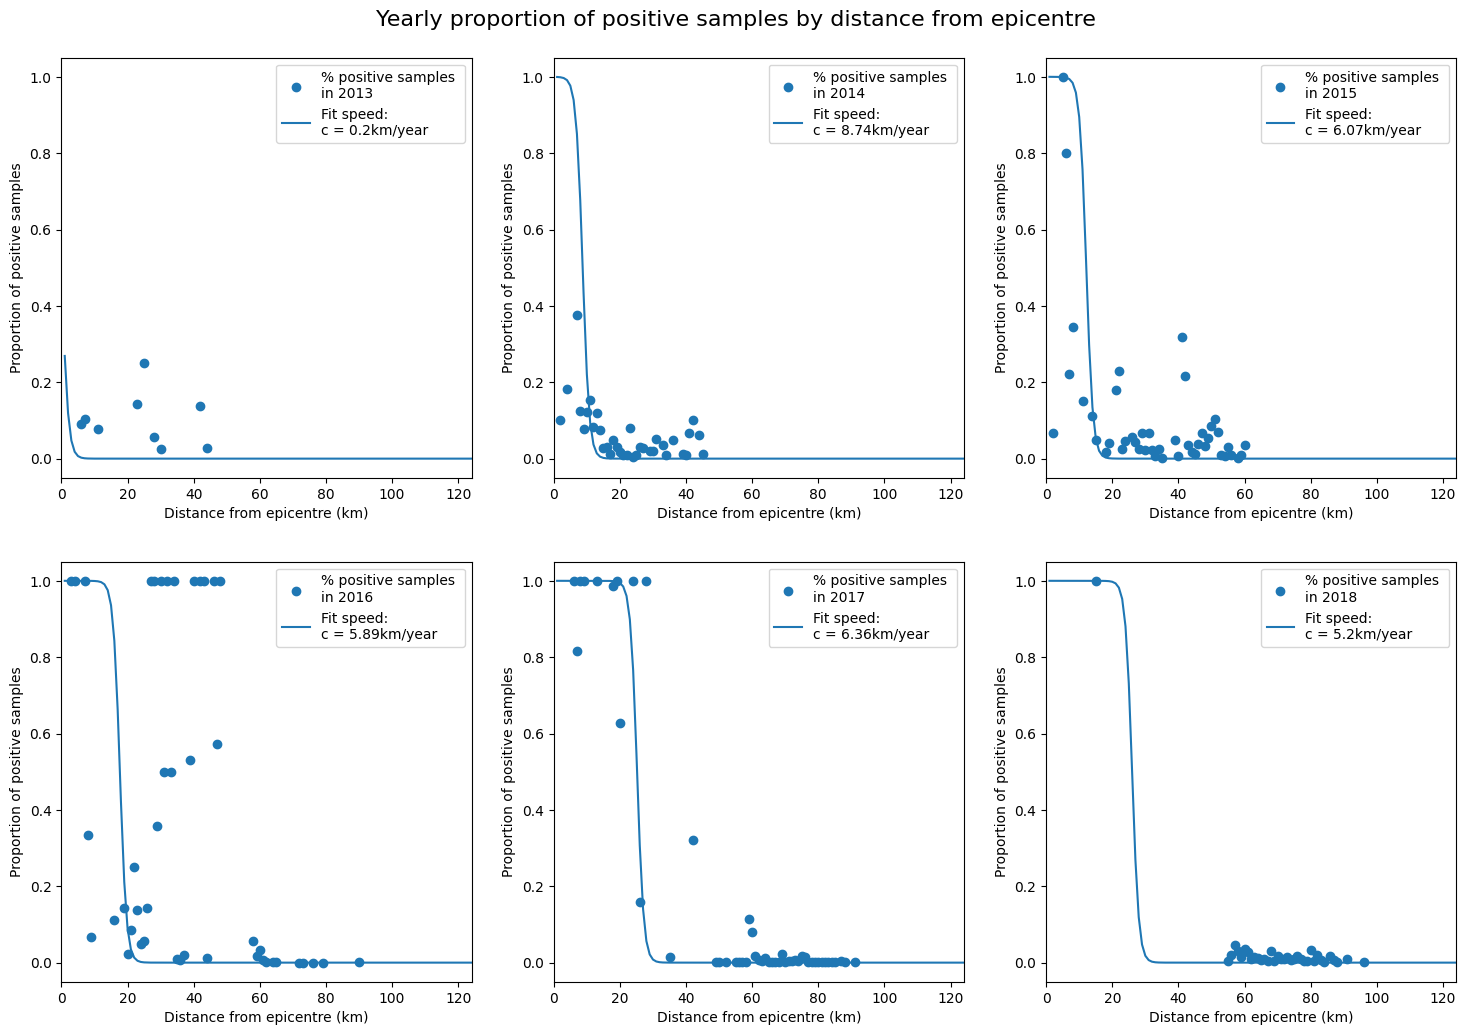

In [18]:
trunc_year_list = [2013, 2014, 2015, 2016, 2017, 2018]

nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*6,nrows*6))
for i, year in enumerate(trunc_year_list):
    x50, c = coefs_log_binom[i]
    x = np.arange(1, max_dist+1)
    mu = 1 / (1 + np.exp(x - (x50 + (year - 2013) * c)))
    dict = class_data(year)
    mask = dict['pos'] > 0

    row = i // ncols
    col = i % ncols

    ax[row, col].scatter(dict['dist'][mask], dict['pos'][mask] / dict['n'][mask], label=f'% positive samples \nin {year}')
    ax[row, col].plot(x, mu, label=f'Fit speed: \nc = {np.round(c,2)}km/year')
    ax[row, col].set_xlabel('Distance from epicentre (km)')
    ax[row, col].set_ylabel('Proportion of positive samples')
    ax[row, col].set_ylim(-0.05, 1.05)
    ax[row, col].set_xlim(-0.05, max_pos+0.05)
    ax[row,col].legend(loc='upper right')
fig.suptitle('Yearly proportion of positive samples by distance from epicentre', fontsize=16, y=0.92)
plt.savefig('Images/Speed_from_data_fit.png', dpi=300)
plt.show()

In [ ]:
# # Plot only positive or negatives
# positives = data_concat[data_concat['RISULTATO'] == 'Positivo']
# negatives = data_concat[data_concat['RISULTATO'] == 'Negativo']

# lat_pos = positives['LATITUDINE'].values
# lon_pos = positives['LONGITUDINE'].values
# lat_neg = negatives['LATITUDINE'].values
# lon_neg = negatives['LONGITUDINE'].values

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# # create map using BASEMAP
# m1 = Basemap(llcrnrlon=lon_min,
#             llcrnrlat=lat_min,
#             urcrnrlon=lon_max,
#             urcrnrlat=lat_max,
#             lat_0=(lat_max - lat_min)/2,
#             lon_0=(lon_max-lon_min)/2,
#             projection='merc',
#             resolution = 'i',
#             area_thresh=10000.,
#             ax = ax[0]
#             )

# m1.drawcoastlines()
# m1.drawcountries()
# m1.drawstates()
# m1.drawmapboundary(fill_color='#46bcec')
# m1.fillcontinents(color='white',lake_color='#46bcec')

# lons_pos, lats_pos = m1(lon_pos, lat_pos)
# m1.scatter(lons_pos, lats_pos, c='red', marker='o', s=10, edgecolor='none', alpha=0.7)

# m2 = Basemap(llcrnrlon=lon_min,
#             llcrnrlat=lat_min,
#             urcrnrlon=lon_max,
#             urcrnrlat=lat_max,
#             lat_0=(lat_max - lat_min)/2,
#             lon_0=(lon_max-lon_min)/2,
#             projection='merc',
#             resolution = 'i',
#             area_thresh=10000.,
#             ax = ax[1]
#             )

# m2.drawcoastlines()
# m2.drawcountries()
# m2.drawstates()
# m2.drawmapboundary(fill_color='#46bcec')
# m2.fillcontinents(color='white',lake_color='#46bcec')

# lons_neg, lats_neg = m2(lon_neg, lat_neg)
# m2.scatter(lons_neg, lats_neg, c='green', marker='o', s=10, edgecolor='none', alpha=0.7)

# # Show the plot
# ax[0].set_title('Positive tests')
# ax[1].set_title('Negative tests')
# plt.show()


In [ ]:
# # PLOT POSITIVE SAMPLES 2013 WEEK BY WEEK

# year = 2014
# year_data = data_concat[data_concat['DATA_RILEVAMENTO'].dt.year == year]
# # date_list = year_data['DATA_RILEVAMENTO'].unique()
# week_list = year_data['SETTIMANA'].unique()
# positives = year_data[year_data['RISULTATO'] == 'Positivo']

# lat_min = 39.7
# lat_max = 40.4
# lon_min = 17.8
# lon_max = 18.5

# # for i, date in enumerate(date_list):
# for i, week in enumerate(week_list):
#     # daily_data = positives[positives['DATA_RILEVAMENTO'] == date].copy()
#     weekly_data = positives[positives['SETTIMANA'] == week].copy()

#     # print(f'Positive tests on {date}: {len(daily_data)}')
#     # print(f'Positive tests on week number {week}, {year}: {len(weekly_data)}')
    
#     # lat = daily_data['LATITUDINE'].values
#     # lon = daily_data['LONGITUDINE'].values
#     lat = weekly_data['LATITUDINE'].values
#     lon = weekly_data['LONGITUDINE'].values
    
#     fig, ax = plt.subplots(figsize=(6,6))
#     m = Basemap(llcrnrlon=lon_min,
#                 llcrnrlat=lat_min,
#                 urcrnrlon=lon_max,
#                 urcrnrlat=lat_max,
#                 lat_0=(lat_max-lat_min)/2,
#                 lon_0=(lon_max-lon_min)/2,
#                 projection='merc',
#                 resolution = 'l',
#                 area_thresh=10000.,
#                 ax=ax
#                 )

#     m.drawcoastlines()
#     m.drawcountries()
#     m.drawstates()
#     m.drawmapboundary(fill_color='#46bcec')
#     m.fillcontinents(color='white',lake_color='#46bcec')

#     lons, lats = m(lon, lat)
#     sc = m.scatter(lons, lats, c='r', marker='o', s=5, edgecolor='none', alpha=1)

#     # ax.set_title(f'Samples {date}')
#     ax.set_title(f'Positive samples in week number {week}, {year}: {len(weekly_data)}')
#     plt.show()

In [ ]:
# # CREATE WEEK COLUMN
# data_concat['SETTIMANA'] = data_concat['DATA_RILEVAMENTO'].dt.isocalendar().week

In [ ]:
# # PLOT DATES AND MAX DISTANCES

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(df_max_distances['DATA_RILEVAMENTO'], df_max_distances['DISTANCE'], marker='o', linestyle='-', color='b')#, label='Max Distance')
# ax.set_xlabel('Date')
# ax.set_ylabel('Max Distance (km)')
# ax.set_title('Maximum Distance from Epicentre Over Time')
# ax.grid(True)
# # ax.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y.values
# print(beta_hat)

# y_hat = model.predict(X)
# residuals = y.values - y_hat
# residual_sum_of_squares = residuals.T @ residuals
# sigma_squared_hat = residual_sum_of_squares / (N - p)
# var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
# for p_ in range(p):
#     standard_error = var_beta_hat[p_, p_] ** 0.5
#     print(f"SE(beta_hat[{p_}]): {standard_error}")


In [ ]:
# # PLOT FIRST GALLIPOLI POSITIVE SAMPLES
# year = 2013
# first_gallipoli = gallipoli[gallipoli['DATA_RILEVAMENTO'].dt.year <= year]

# # Coordinate data of samples
# gal_lat = first_gallipoli['LATITUDINE'].values
# gal_lon = first_gallipoli['LONGITUDINE'].values
# limits = get_limits(gal_lat, gal_lon, margin=0.1)

# fig, ax = plt.subplots(figsize=(8,8))
# m = create_map(limits, ax, 'i')
# gal_lons, gal_lats = m(gal_lon, gal_lat)
# sc = m.scatter(gal_lons, gal_lats, c=first_gallipoli['COLOR'].values, marker='o', s=10, edgecolor='none', alpha=0.5)

# plt.title(f'{np.arange(2013, year+1)} Gallipoli positive samples')
# plt.show()

In [ ]:
# # EXTRACT FIRST CASES (GALLIPOLI, 2013)
# gallipoli = positives[positives['COMUNE'] == 'Gallipoli']

# # Determine epicentre coordinates arbitrarily: average of first cases (2013)
# first_cases = gallipoli[gallipoli['DATA_RILEVAMENTO'].dt.year == 2013]
# epicentre = {'lat': np.mean(first_cases['LATITUDINE']), 'lon': np.mean(first_cases['LONGITUDINE'])}
# # epicentre_point = (epicentre['lat'], epicentre['lon'])
# epicentre_point = (40.055851, 17.992615) # Taken from Kottelenberg (2021)


In [ ]:
# year = 2014
# percentage = []
# yearly_data = data_concat[data_concat['DATA_RILEVAMENTO'].dt.year == year]
# classes = sorted(np.unique(yearly_data['CLASS'].values))

# for Class in classes:
#     class_data = yearly_data[yearly_data['CLASS'] == Class]
#     samples = len(class_data)
#     if samples == 0:
#         percentage.append(0)
#     else:
#         percentage.append(len(class_data[class_data['RISULTATO'] == 'Positivo']) / samples)

# fig, ax = plt.subplots(figsize=(8,6))
# ax.scatter(classes, percentage)